In [83]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta

%matplotlib inline

In [84]:
def import_stock_data(tickers, start = '2010-1-1', end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [148]:
data = import_stock_data(['AAPL'])

In [149]:
data.tail()


,AAPL
Date,
2022-07-01,138.929993
2022-07-05,141.559998
2022-07-06,142.919998
2022-07-07,146.350006
2022-07-08,146.639999


In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3150 entries, 2010-01-04 to 2022-07-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    3150 non-null   float64
dtypes: float64(1)
memory usage: 49.2 KB


In [151]:
data.isnull().sum()

AAPL    0
dtype: int64

In [152]:
def log_returns(data):
    return np.log(1 + data.pct_change())

In [153]:
def simple_returns(data):
    return (data / data.shift(1)) - 1

In [154]:
log_return = log_returns(data)
log_return.head()

,AAPL
Date,
2010-01-04,NaN
2010-01-05,0.001727
2010-01-06,-0.016034
2010-01-07,-0.001851
2010-01-08,0.006627


In [155]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [156]:
drift = drift_calc(data)
drift

array([0.00082755])

In [157]:
stdev = log_returns(data).std().values
stdev

array([0.01790604])

In [158]:
def get_tickers(data):
    tickers = [i for i in data.columns]
    return tickers
tickers=get_tickers(data)
tickers

['AAPL']

In [159]:
def probs_find(predicted, higherthan, ticker = None, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    4. ticker: specific ticker to compute probability for
    """
    if ticker == None:
        if on == 'return':
            predicted0 = predicted.iloc[0,0]
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
            less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
        elif on == 'value':
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [i for i in predList if i >= higherthan]
            less = [i for i in predList if i < higherthan]
        else:
            print("'on' must be either value or return")
    else:
        if on == 'return':
            predicted = predicted[predicted['ticker'] == ticker]
            predicted0 = predicted.iloc[0,0]
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
            less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
        elif on == 'value':
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [i for i in predList if i >= higherthan]
            less = [i for i in predList if i < higherthan]
        else:
            print("'on' must be either value or return")        
    return len(over) / (len(over) + len(less))

In [160]:
def montecarlo_cholesky(tickers, days, iterations, start='2010-1-1', show_hist = False, show_line = False, show_stats=True):
    #Get tickers and number of tickers involved in this portfolio
    data = import_stock_data(tickers, start=start)
    ticks = get_tickers(data)
    numstocks = len(ticks)
    
    #Basic information and data
    log_return = log_returns(data)
    
    #Brownian motion component: drif
    drift = drift_calc(data)
    stdev = log_returns(data).std().values
    
    #Cholesky decomposition
    covari = log_return.cov()
    chol = np.linalg.cholesky(covari)
    
    #Generate uncorralated random variables and use cholesky decomposition to correlate them
    uncorr_x = norm.ppf(np.random.rand(numstocks,iterations*days))
    corr_x = np.dot(chol, uncorr_x)
    
    #Calculate daily return
    corr_2 = np.zeros_like(corr_x)
    for i in range(numstocks):
        corr_2[i] = np.exp(drift[i] + corr_x[i])
    simulatedDF = []    
    #For every stock, calculate the returns
    for s in range(len(ticks)):
        ret_reshape = corr_2[s]
        ret_reshape = ret_reshape.reshape(days,iterations)
        price_list = np.zeros_like(ret_reshape)
        price_list[0] = data.iloc[-1,s]
        #Calculate returns for the s stock
        for t in range(1,days):
            price_list[t] = price_list[t-1]*ret_reshape[t]
        
        #Create dataframe for this run, input the name of stock and load
        y = pd.DataFrame(price_list)   
        y['ticker'] = tickers[s]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
        
        #plotting
        if show_hist == True:
            x = pd.DataFrame(price_list).iloc[-1]
            fig, ax = plt.subplots(1,2, figsize=(14,4))
            sns.distplot(x, ax=ax[0],axlabel="Stock Price")
            sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
            plt.xlabel("Stock Price")
            plt.show()
        if show_line == True:
            y = pd.DataFrame(price_list[:,0:10]).plot(figsize=(15,6))
        
        if show_stats == True:
        #Printing basic stats
            print(ticks[s])
            print(f"Days: {days}")
            print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
            print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
            print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
        
    simulatedDF = pd.concat(simulatedDF)
    return(simulatedDF)

C:\Users\samma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\samma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


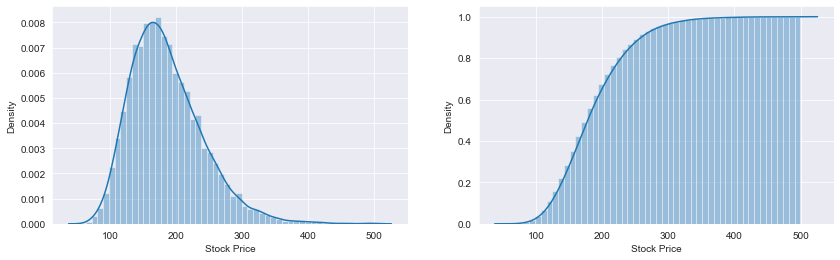

AAPL
Days: 252
Expected Value: $185.75
Return: 21.04%
Probability of Breakeven: 0.7488


C:\Users\samma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\samma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


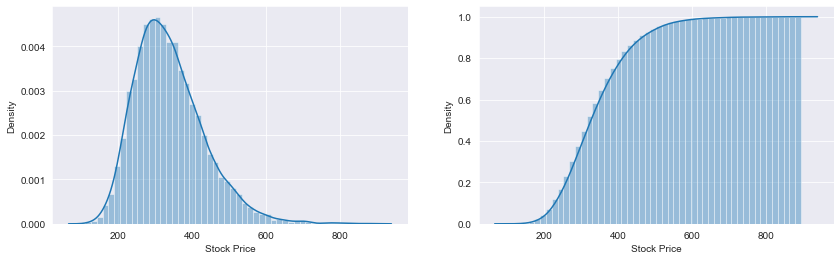

MSFT
Days: 252
Expected Value: $338.95
Return: 22.0%
Probability of Breakeven: 0.7808


C:\Users\samma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\samma\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


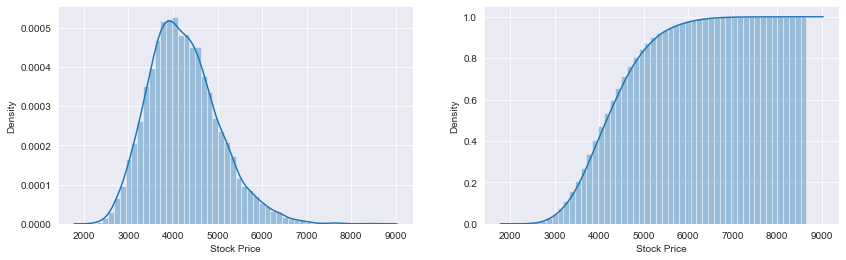

^GSPC
Days: 252
Expected Value: $4238.63
Return: 8.35%
Probability of Breakeven: 0.643


In [161]:
x = montecarlo_cholesky(['AAPL','MSFT','^GSPC'], days=252, iterations=10000, start='2015-1-1', show_hist=True)

In [162]:
x

,ticker,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,AAPL,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,...,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993,146.679993
1,AAPL,144.174529,148.642748,142.296628,147.925501,150.148419,147.380316,142.832070,144.745461,153.701287,...,145.044320,149.056942,148.743504,141.186036,148.136878,146.934305,148.314780,147.885254,145.363158,144.347475
2,AAPL,145.656381,149.399944,143.419758,148.534343,155.071788,150.945062,142.326858,145.141854,153.300208,...,147.604023,147.306642,149.532084,138.810836,143.942014,150.562722,143.544172,150.538024,149.207652,146.905269
3,AAPL,141.661169,151.387786,144.387458,147.978084,159.242770,151.001597,143.517992,142.295924,152.070745,...,146.159015,146.405362,148.634311,136.495811,146.229369,145.102119,140.330803,149.856076,150.972366,146.253604
4,AAPL,143.648860,148.395055,146.036305,148.010531,159.040987,147.818982,145.721227,143.953605,154.329281,...,149.803230,145.641234,148.310785,139.601539,146.238035,142.904496,138.833322,149.629277,155.218659,145.809076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,^GSPC,4224.070788,5341.358517,4375.059341,4629.987899,4560.395011,4158.609056,4270.581968,3737.503667,4503.859936,...,4169.998703,4596.699637,4487.004216,3678.713368,5371.523735,4897.509285,3487.618303,4252.100828,3709.665864,3298.113340
248,^GSPC,4168.178697,5300.802533,4290.650881,4601.343453,4538.738049,4111.272899,4229.564750,3744.539469,4529.530309,...,4157.532250,4604.776072,4455.611196,3698.003921,5331.418314,4871.023008,3524.087031,4179.090567,3787.082228,3252.108246
249,^GSPC,4170.804655,5228.414416,4292.924014,4625.656357,4584.034889,4093.665549,4239.237749,3814.850153,4493.886814,...,4209.858219,4647.499867,4448.673677,3743.504874,5333.517551,4925.445944,3487.138620,4154.582128,3774.077963,3170.113308
250,^GSPC,4079.048557,5173.902512,4267.779175,4651.239827,4552.575411,4031.170565,4229.225193,3726.721465,4557.599355,...,4219.340480,4596.327080,4420.526743,3833.433788,5460.097591,4822.452880,3550.769040,4196.106794,3722.822085,3130.326472


In [163]:
[col for col in data.columns]

['AAPL']

## Sharpe Ratio

In [164]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    ticks = [col for col in data.columns]
    if mark_ticker in ticks:
        ann_return = np.exp(log_returns(data).mean()*252).values-1
    else:
        market_data = import_stock_data(mark_ticker, start)
        market_rets = log_returns(market_data).dropna()
        ann_return = np.exp(market_rets.mean()*252).values-1
        data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [165]:
a,b=market_data_combination(data)

In [166]:
a.head()

,AAPL,^GSPC
Date,,
2010-01-04,6.535085,1132.989990
2010-01-05,6.546383,1136.520020
2010-01-06,6.442255,1137.140015
2010-01-07,6.430344,1141.689941
2010-01-08,6.473096,1144.979980


In [167]:
b

array([0.10363701])

In [176]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025, riskpremium = 0.05):
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start) #load data and annual returns
    log_ret = log_returns(dd) # create the logarithmic returns of the data
    covar = log_ret.cov()*252 #Annualized covariance matrix 
    covar = pd.DataFrame(covar.iloc[:-1,-1]) # Get the part of the covariance matrix that is related between the stocks and the market
    mrk_var = log_ret.iloc[:,-1].var()*252 # Annualized variance of market
    beta = covar/mrk_var # Now we have our betas!
    
    #Add the standard deviation to the beta dataframe
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # Get tickers of all the stocks in the dataframe used
    tickers = get_tickers(dd)

    
    # Make dictionary for the annual return of each stock
    #mark_ret = {tickers[i] : mark_ret[i] for i in range(len(tickers))}


    # CAPM
    """for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret[mark_ticker]-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)"""
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [177]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
AAPL,1.095397,0.283119,0.111135,0.304236


In [178]:
data.head()

,AAPL
Date,
2010-01-04,6.535085
2010-01-05,6.546383
2010-01-06,6.442255
2010-01-07,6.430344
2010-01-08,6.473096


# Portfolio Optimization

First, we will create a portfolio optimizer that determines the allocation of weights among data that we have - data that is not generated.

Second, we will replicate the same portfolio algorythm, only this time with the average predicted values of all the runs into the future. 

In [179]:
data.head()

,AAPL
Date,
2010-01-04,6.535085
2010-01-05,6.546383
2010-01-06,6.442255
2010-01-07,6.430344
2010-01-08,6.473096


In [180]:
data.shape

(3150, 1)

In [182]:
log_return = log_returns(data)

weights = np.array(np.random.random(4))
weights = weights/np.sum(weights)

expected_ret = np.sum((log_return.mean()*weights)*252)

expected_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))

sharpe = (expected_ret-0.025)/expected_vol

print(f"Weights: {weights}")
print(f"Expected Return of Portfolio: {expected_ret}")
print(f"Expected Volatility: {expected_vol}")
print(f"Sharpe Ratio: {sharpe}")

ValueError: Length of values (4) does not match length of index (1)

In [183]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [184]:
import_stock_data(['MSFT','AMZN'])

,MSFT,AMZN
Date,,
2010-01-04,23.800224,6.695000
2010-01-05,23.807913,6.734500
2010-01-06,23.661806,6.612500
2010-01-07,23.415726,6.500000
2010-01-08,23.577219,6.676000
...,...,...
2022-07-01,259.579987,109.559998
2022-07-05,262.850006,113.500000
2022-07-06,266.209991,114.330002


In [185]:
def montecarlo_sharpe_optimal_portfolio(tickers, trials, riskfree=0.025, plot_eff = True, start_date = '2010-1-1', end_date=None):
    if end_date == None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    data = import_stock_data(tickers)
    allWeights = np.zeros((trials, len(data.columns)))
    allReturns = np.zeros(trials)
    allVolatility = np.zeros(trials)
    allSharpeValues = np.zeros(trials)
    
    log_return = log_returns(data)
    
    for t in range(trials):
        weights = np.random.rand(len(data.columns))
        weights = weights/np.sum(weights) 
        allWeights[t,:]=weights
        
        allReturns[t] = np.sum((log_return.mean()*weights)*252)
        
        allVolatility[t] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))
        
        allSharpeValues[t] = (allReturns[t]-riskfree)/allVolatility[t]
    
    maxsharpe = allSharpeValues.max()
    pointsharpe = allSharpeValues.argmax()
    weightSharpe = allWeights[pointsharpe]
    x_sharpe = allVolatility[pointsharpe]
    y_sharpe = allReturns[pointsharpe]
    
    maxret = allReturns.max()
    pointret = allReturns.argmax()
    weightRet = allWeights[pointret]
    x_ret = allVolatility[pointret]
    y_ret = allReturns[pointret]
    
 
    if plot_eff == True:
        plt.figure(figsize=(14,9))
        plt.scatter(allVolatility, allReturns, c=allSharpeValues, cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        
        plt.scatter(x_sharpe,y_sharpe,c='black')
        plt.scatter(x_ret, y_ret, c='black')
       
    optim_dic = []
    for i in range(len(tickers)):
        optim_dic.append({'ticker':tickers[i],'Weight':weightSharpe[i]})
    print(pd.DataFrame(optim_dic))

  ticker    Weight
0   MSFT  0.335009
1    UNH  0.664991


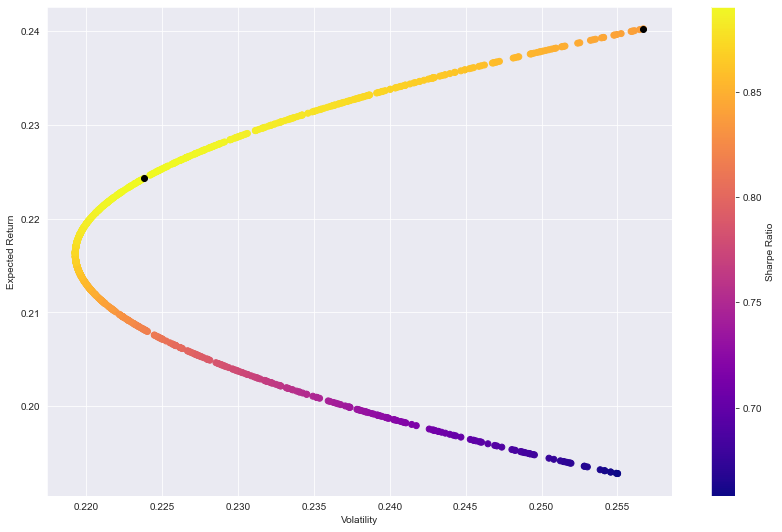

In [186]:
montecarlo_sharpe_optimal_portfolio(['MSFT','UNH'],1000)

In [187]:
import_stock_data(['MSFT','AMZN','AMZN'])

ValueError: Columns must be same length as key